In [1]:
import pandas as pd
import requests
from datetime import datetime
import json

pd.set_option('display.max_columns', None)

# Load configuration from JSON file
with open('config.json') as config_file:
    config = json.load(config_file)
    GOOGLE_MAPS_API_KEY = config['GOOGLE_MAPS_API_KEY']
    token = config['fuel_token']

# Set your API token
#token = "5067f5e2-7e7f-49a7-bf4e-69b069e204c4"  # Replace with your actual token

# Set the headers for the request
headers = {
    "Authorization": f"FPDAPI SubscriberToken={token}",
    "Content-Type": "application/json"
}

# Step 1: Get Fuel Types
url_fuel_types = "https://fppdirectapi-prod.fuelpricesqld.com.au/Subscriber/GetCountryFuelTypes"
response_fuel_types = requests.get(url_fuel_types, headers=headers, params={"countryId": "21"})
df_fuel_types = pd.DataFrame()
if response_fuel_types.status_code == 200:
    fuel_types_data = response_fuel_types.json()['Fuels']
    df_fuel_types = pd.json_normalize(fuel_types_data)

# Step 2: Get Brands
url_brands = "https://fppdirectapi-prod.fuelpricesqld.com.au/Subscriber/GetCountryBrands"
response_brands = requests.get(url_brands, headers=headers, params={"countryId": "21"})
df_brands = pd.DataFrame()
if response_brands.status_code == 200:
    brands_data = response_brands.json()['Brands']
    df_brands = pd.json_normalize(brands_data)

# Step 3: Get Site Details
url_site_details = "https://fppdirectapi-prod.fuelpricesqld.com.au/Subscriber/GetFullSiteDetails"
response_sites = requests.get(url_site_details, headers=headers, params={"countryId": "21", "GeoRegionLevel": "3", "GeoRegionId": "1"})
df_sites_all = pd.DataFrame()
if response_sites.status_code == 200:
    sites_data = response_sites.json()['S']  # Assuming the key is 'Sites'
    df_sites_all = pd.json_normalize(sites_data)
    df_sites_all.rename(columns={
        'S': 'Site ID',
        'N': 'Name',
        'A': 'Address',
        'B': 'Brand ID',
        'P': 'Postcode',
        'G1': 'Geographic Region Level 1',
        'G2': 'Geographic Region Level 2',
        'G3': 'Geographic Region Level 3',
        'G4': 'Geographic Region Level 4',
        'G5': 'Geographic Region Level 5',
        'Lat': 'Latitude',
        'Lng': 'Longitude',
        'M': 'Last Modified',
        'GPI': 'Google Place ID'
    }, inplace=True)

# Step 4: Get Site Prices
url_site_prices = "https://fppdirectapi-prod.fuelpricesqld.com.au/Price/GetSitesPrices"
response_prices = requests.get(url_site_prices, headers=headers, params={"countryId": "21", "geoRegionLevel": "3", "geoRegionId": "1"})
df_fuel_prices = pd.DataFrame()
if response_prices.status_code == 200:
    fuel_prices_data = response_prices.json()['SitePrices']
    df_fuel_prices = pd.json_normalize(fuel_prices_data)

# Step 5: Merge DataFrames
# Merge site details with brands using 'Brand ID'
merged_df = pd.merge(df_sites_all, df_brands, left_on='Brand ID', right_on='BrandId', how='left')

# Merge fuel prices with sites using 'Site ID'
merged_df = pd.merge(merged_df, df_fuel_prices, left_on='Site ID', right_on='SiteId', how='left')

# Merge fuel types with prices using 'FuelId'
merged_df = pd.merge(merged_df, df_fuel_types, left_on='FuelId', right_on='FuelId', how='left')

# Select and rename the desired columns
final_df = merged_df[[
    'Site ID', 'Address', 'Name_x', 'Postcode', 'Latitude', 
    'Longitude', 'Google Place ID', 'Name_y', 'TransactionDateUtc', 
    'Price', 'Name','FuelId'
]].rename(columns={
    'Site ID': 'site_id',
    'Address': 'address',
    'Name_x': 'station_name',
    'Postcode': 'postcode',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'Google Place ID': 'gp_id',
    'Name_y': 'brand_name',
    'TransactionDateUtc': 'transaction_date_time',
    'Price': 'price',
    'Name': 'fuel_name'
})

# Create a timestamp for the file name
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f'fuel_data_{timestamp}.csv'

# Save the final DataFrame as a CSV file
final_df.to_csv(file_name, index=False)

# Display the first few rows of the final DataFrame
print(final_df.head())

    site_id            address        station_name postcode   latitude   
0  61290151     61 Burrowes St       Liberty Surat     4417 -27.151627  \
1  61290151     61 Burrowes St       Liberty Surat     4417 -27.151627   
2  61290151     61 Burrowes St       Liberty Surat     4417 -27.151627   
3  61291313  126 Barwon Street  Lowes Mungindi Opt     4497 -28.973667   
4  61291313  126 Barwon Street  Lowes Mungindi Opt     4497 -28.973667   

    longitude                        gp_id brand_name   
0  149.067712  ChIJhbUB8XJVumsR1WCVwJFOMiY    Liberty  \
1  149.067712  ChIJhbUB8XJVumsR1WCVwJFOMiY    Liberty   
2  149.067712  ChIJhbUB8XJVumsR1WCVwJFOMiY    Liberty   
3  148.983999  ChIJWyNloETOpWsR2iAu7eiMx30         BP   
4  148.983999  ChIJWyNloETOpWsR2iAu7eiMx30         BP   

     transaction_date_time   price            fuel_name  FuelId  
0  2024-06-02T23:56:20.107  1899.0             Unleaded     2.0  
1   2024-08-23T23:49:59.33  1899.0               Diesel     3.0  
2  2024-06-02T

In [2]:
# Function to filter out outliers based on the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from the 'price' column in final_df
final_df_filtered = remove_outliers(final_df, 'price')

# Display the first few rows of the filtered DataFrame
print(final_df_filtered.head())

    site_id            address        station_name postcode   latitude   
0  61290151     61 Burrowes St       Liberty Surat     4417 -27.151627  \
1  61290151     61 Burrowes St       Liberty Surat     4417 -27.151627   
2  61290151     61 Burrowes St       Liberty Surat     4417 -27.151627   
3  61291313  126 Barwon Street  Lowes Mungindi Opt     4497 -28.973667   
4  61291313  126 Barwon Street  Lowes Mungindi Opt     4497 -28.973667   

    longitude                        gp_id brand_name   
0  149.067712  ChIJhbUB8XJVumsR1WCVwJFOMiY    Liberty  \
1  149.067712  ChIJhbUB8XJVumsR1WCVwJFOMiY    Liberty   
2  149.067712  ChIJhbUB8XJVumsR1WCVwJFOMiY    Liberty   
3  148.983999  ChIJWyNloETOpWsR2iAu7eiMx30         BP   
4  148.983999  ChIJWyNloETOpWsR2iAu7eiMx30         BP   

     transaction_date_time   price            fuel_name  FuelId  
0  2024-06-02T23:56:20.107  1899.0             Unleaded     2.0  
1   2024-08-23T23:49:59.33  1899.0               Diesel     3.0  
2  2024-06-02T

Closest Station to 24 Hyde Rd, Brisbane: 7-Eleven Yeronga
Closest Station to 1 Wood St, Brisbane: Costco Ipswich Fuel Station


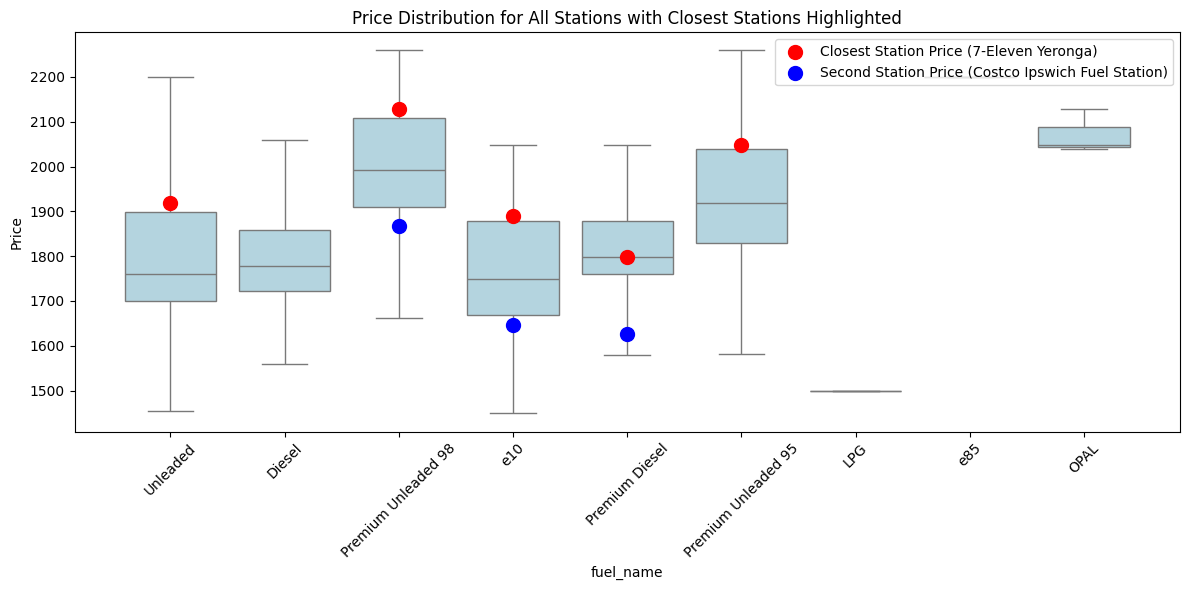

In [3]:
import pandas as pd
import requests
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate distance between two points (latitude, longitude)
def calculate_distance(location1, location2):
    return geodesic(location1, location2).kilometers

# Function to get latitude and longitude from address using Nominatim (OpenStreetMap)
def get_lat_lon_from_address(address):
    url = f"https://nominatim.openstreetmap.org/search?q={address}&format=json"
    
    headers = {
        'User-Agent': 'YourAppName/1.0 (your.email@example.com)'  # Set your custom User-Agent
    }
    
    try:
        response = requests.get(url, headers=headers)
        data = response.json()
        
        if len(data) > 0:
            lat, lon = float(data[0]['lat']), float(data[0]['lon'])
            return lat, lon
        else:
            print(f"No results found for address: {address}")
            return None, None
    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
        return None, None

def find_closest_stations(address, stations_df, num_stations=1):
    # Get latitude and longitude for the input address
    address_lat_lon = get_lat_lon_from_address(address)  
    
    if address_lat_lon is None:
        print(f"Could not find coordinates for address: {address}")
        return None

    # Group by unique station (station_name, latitude, longitude, and site_id) to remove duplicates
    unique_stations = stations_df.groupby(['station_name', 'latitude', 'longitude', 'site_id'], as_index=False).first()

    # Calculate distance of all unique stations from the input address
    unique_stations['distance'] = unique_stations.apply(
        lambda row: calculate_distance(address_lat_lon, (row['latitude'], row['longitude'])), axis=1
    )

    # Sort by distance and get the closest station(s)
    closest_stations = unique_stations.nsmallest(num_stations, 'distance')

    return closest_stations

# Function to visualize price ranges for two addresses (show the closest station prices for each)
def visualize_price_ranges_two_addresses(address_1, address_2, final_df_filtered):
    # Find the closest stations to both addresses
    closest_station_1 = find_closest_stations(address_1, final_df_filtered, num_stations=1)
    closest_station_2 = find_closest_stations(address_2, final_df_filtered, num_stations=1)
    
    if closest_station_1 is None or closest_station_1.empty:
        print(f"No stations found near {address_1}")
        return

    if closest_station_2 is None or closest_station_2.empty:
        print(f"No stations found near {address_2}")
        return

    # Get the name and ID of the closest station for both addresses
    closest_station_name_1 = closest_station_1['station_name'].values[0]
    closest_station_id_1 = closest_station_1['site_id'].values[0]

    closest_station_name_2 = closest_station_2['station_name'].values[0]
    closest_station_id_2 = closest_station_2['site_id'].values[0]
    
    print(f"Closest Station to {address_1}: {closest_station_name_1}")
    print(f"Closest Station to {address_2}: {closest_station_name_2}")

    # Prepare data for the closest stations
    closest_data_1 = final_df_filtered[final_df_filtered['site_id'] == closest_station_id_1]
    closest_data_2 = final_df_filtered[final_df_filtered['site_id'] == closest_station_id_2]

    # Create a figure for box plots
    plt.figure(figsize=(12, 6))

    # Create a box plot for all fuel types across all stations
    sns.boxplot(x='fuel_name', y='price', data=final_df_filtered, color='lightblue', showfliers=False)
    
    # Add red dots for address_1 (first site)
    for _, row in closest_data_1.iterrows():
        plt.scatter(x=row['fuel_name'], y=row['price'], color='red', zorder=10, s=100, 
                    label=f'Closest Station Price ({closest_station_name_1})' if row['fuel_name'] == closest_data_1['fuel_name'].values[0] else "")

    # Add blue dots for address_2 (second site)
    for _, row in closest_data_2.iterrows():
        plt.scatter(x=row['fuel_name'], y=row['price'], color='blue', zorder=10, s=100, 
                    label=f'Second Station Price ({closest_station_name_2})' if row['fuel_name'] == closest_data_2['fuel_name'].values[0] else "")

    plt.title('Price Distribution for All Stations with Closest Stations Highlighted')
    plt.ylabel('Price')

    # Add a legend
    plt.legend(loc='upper right')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

# Example usage
address_1 = '24 Hyde Rd, Brisbane'  # Replace with the first address
address_2 = '1 Wood St, Brisbane'  # Replace with the second address

# Assuming final_df_filtered is your DataFrame containing station prices and information
visualize_price_ranges_two_addresses(address_1, address_2, final_df_filtered)

Unique Stations with Distances:
                       station_name     distance
0     7-Eleven  Bracken Ridge North    22.615066
1             7-Eleven Acacia Ridge     8.401297
2        7-Eleven Acacia Ridge East     7.165719
3               7-Eleven Aitkenvale  1111.248574
4             7-Eleven Albany Creek    16.669028
...                             ...          ...
1637                 Yandaran Store   322.316148
1638             Yelarbon Roadhouse   251.720309
1639            Yungaburra Pit Stop  1367.484316
1640          Zenna's General Store  1341.820619
1641    Zims Corner Service Station   119.671078

[1642 rows x 2 columns]
Closest Station:
         station_name   latitude   longitude   site_id   
181  7-Eleven Yeronga -27.519525  153.015255  61401188  \

                          address postcode                        gp_id   
181  563 Fairfield Rd & Nelson St     4104  ChIJHykiiZ1akWsR6eo2ZjUfs-E  \

    brand_name  transaction_date_time   price fuel_name  FuelId  dista

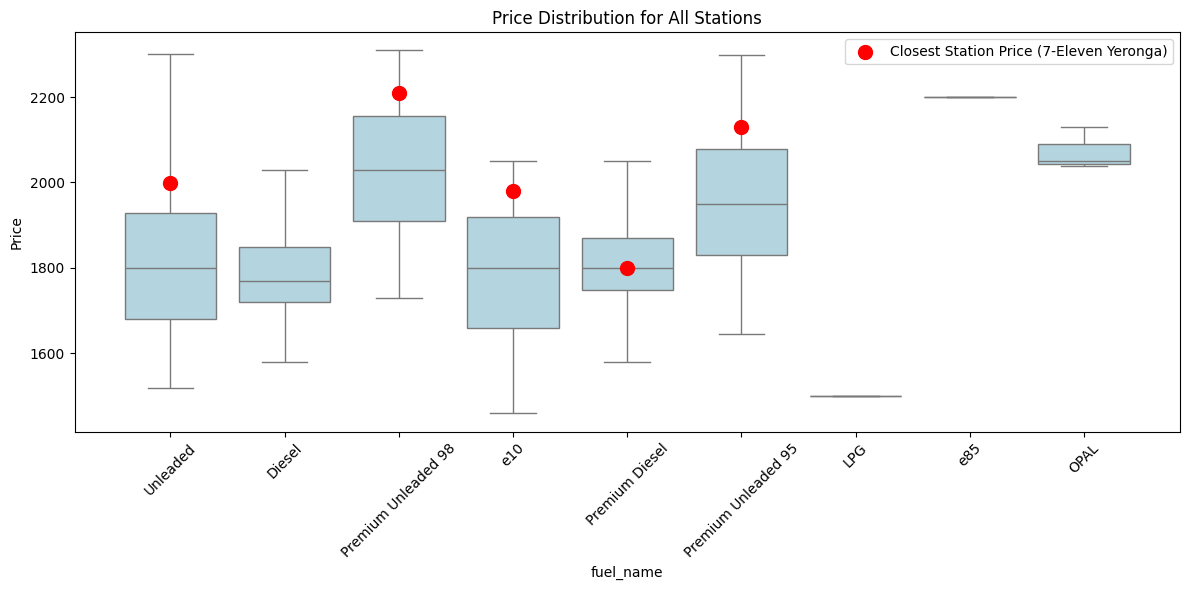

Stations within 20 km of 24 Hyde Rd, Brisbane:
                    station_name   distance
1          7-Eleven Acacia Ridge   8.401297
2     7-Eleven Acacia Ridge East   7.165719
4          7-Eleven Albany Creek  16.669028
5              7-Eleven Algester  11.136777
6                 7-Eleven Ascot  10.420391
...                          ...        ...
1598             United Sherwood   4.005639
1603          United Springfield  18.445073
1604      United Sunnybank Hills   9.694605
1610             United Virginia  15.775842
1614        United Woolloongabba   3.405055

[322 rows x 2 columns]
Unique Stations with Distances:
                       station_name     distance
0     7-Eleven  Bracken Ridge North    22.615066
1             7-Eleven Acacia Ridge     8.401297
2        7-Eleven Acacia Ridge East     7.165719
3               7-Eleven Aitkenvale  1111.248574
4             7-Eleven Albany Creek    16.669028
...                             ...          ...
1637                 Yanda

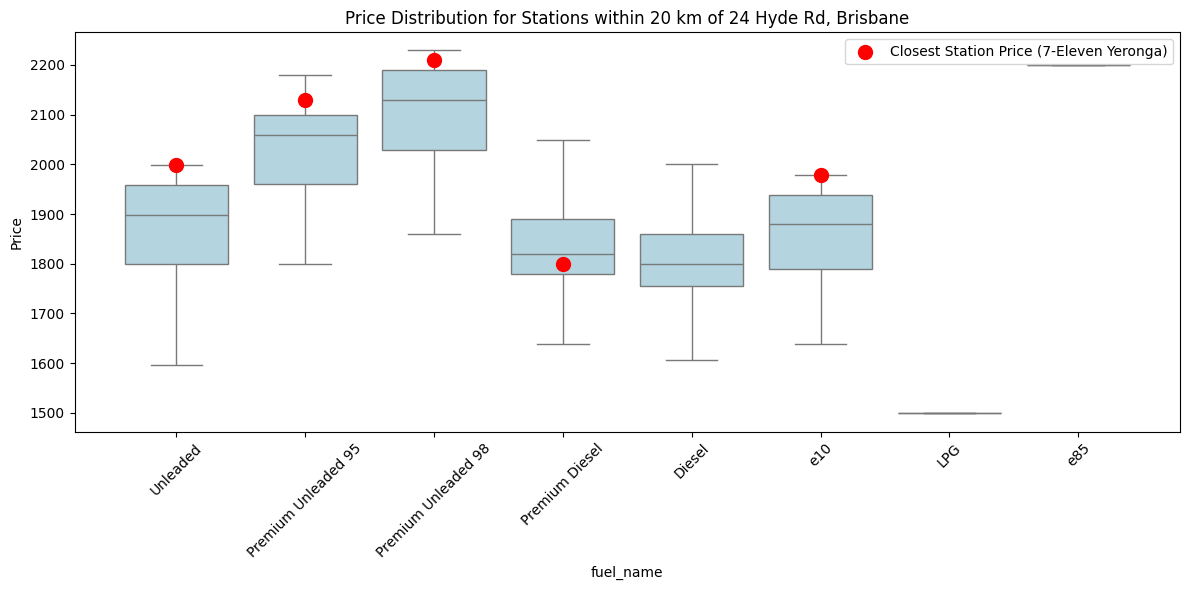

In [4]:
import pandas as pd
import requests
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate distance between two points (latitude, longitude)
def calculate_distance(location1, location2):
    return geodesic(location1, location2).kilometers

# Function to get latitude and longitude from address using Nominatim (OpenStreetMap)
def get_lat_lon_from_address(address):
    url = f"https://nominatim.openstreetmap.org/search?q={address}&format=json"
    
    headers = {
        'User-Agent': 'YourAppName/1.0 (your.email@example.com)'  # Set your custom User-Agent
    }
    
    try:
        response = requests.get(url, headers=headers)
        data = response.json()
        
        if len(data) > 0:
            lat, lon = float(data[0]['lat']), float(data[0]['lon'])
            return lat, lon
        else:
            print(f"No results found for address: {address}")
            return None, None
    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
        return None, None

def find_closest_stations(address, stations_df, num_stations=1):
    # Get latitude and longitude for the input address
    address_lat_lon = get_lat_lon_from_address(address)  
    
    if address_lat_lon is None:
        print(f"Could not find coordinates for address: {address}")
        return None

    # Group by unique station (station_name, latitude, longitude, and site_id) to remove duplicates
    unique_stations = stations_df.groupby(['station_name', 'latitude', 'longitude', 'site_id'], as_index=False).first()

    # Calculate distance of all unique stations from the input address
    unique_stations['distance'] = unique_stations.apply(
        lambda row: calculate_distance(address_lat_lon, (row['latitude'], row['longitude'])), axis=1
    )

    # Debug: Print distances to see what we are working with
    print("Unique Stations with Distances:")
    print(unique_stations[['station_name', 'distance']])

    # Sort by distance and get the closest station(s)
    closest_stations = unique_stations.nsmallest(num_stations, 'distance')

    # Ensure only one closest station is returned even if there are ties
    if closest_stations.shape[0] > 1:
        # If there are multiple closest stations, select the first one
        closest_stations = closest_stations.head(1)

    # Debug: Check the closest stations returned
    print("Closest Station:")
    print(closest_stations)

    return closest_stations

# Function to visualize price ranges for the closest station and highlight its price
def visualize_price_ranges_closest_station(address, final_df_filtered):
    # Find the closest station to the given address
    closest_station = find_closest_stations(address, final_df_filtered, num_stations=1)
    
    if closest_station is None or closest_station.empty:
        print(f"No stations found near {address}")
        return

    # Get the name and ID of the closest station
    closest_station_name = closest_station['station_name'].values[0]
    closest_station_id = closest_station['site_id'].values[0]
    
    print(f"Closest Station to {address}: {closest_station_name}")

    # Prepare a DataFrame to hold data from the closest station
    closest_data = final_df_filtered[final_df_filtered['site_id'] == closest_station_id]

    if closest_data.empty:
        print(f"No data found for the closest station.")
        return

    # Print the prices of the closest station along with fuel types
    print("Prices of the Closest Station:")
    for _, row in closest_data.iterrows():
        print(f"Station ID: {closest_station_id}, Fuel Type: {row['fuel_name']}, Price: {row['price']}")

    # Create a figure for box plots
    plt.figure(figsize=(12, 6))

    # Create a box plot for all fuel types across all stations
    sns.boxplot(x='fuel_name', y='price', data=final_df_filtered, color='lightblue', showfliers=False)
    
    # Add red dots for the closest station's prices
    for _, row in closest_data.iterrows():
        plt.scatter(x=row['fuel_name'], y=row['price'], color='red', zorder=10, s=100, 
                    label=f'Closest Station Price ({closest_station_name})' if row['fuel_name'] == closest_data['fuel_name'].values[0] else "")

    plt.title('Price Distribution for All Stations')
    plt.ylabel('Price')

    # Add a legend
    plt.legend(loc='upper right')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()



def find_stations_within_radius(address, stations_df, radius_km=10):
    # Get latitude and longitude for the input address
    address_lat_lon = get_lat_lon_from_address(address)  
    
    if address_lat_lon is None:
        print(f"Could not find coordinates for address: {address}")
        return None

    # Group by unique station (station_name, latitude, longitude, and site_id) to remove duplicates
    unique_stations = stations_df.groupby(['station_name', 'latitude', 'longitude', 'site_id'], as_index=False).first()

    # Calculate distance of all unique stations from the input address
    unique_stations['distance'] = unique_stations.apply(
        lambda row: calculate_distance(address_lat_lon, (row['latitude'], row['longitude'])), axis=1
    )

    # Filter stations within the specified radius
    stations_within_radius = unique_stations[unique_stations['distance'] <= radius_km]
    
    return stations_within_radius

def visualize_price_ranges_within_radius(address, final_df_filtered, radius_km=10):
    # Find all stations within the specified radius
    stations_within_radius = find_stations_within_radius(address, final_df_filtered, radius_km)
    
    if stations_within_radius is None or stations_within_radius.empty:
        print(f"No stations found within {radius_km} km of {address}")
        return

    print(f"Stations within {radius_km} km of {address}:")
    print(stations_within_radius[['station_name', 'distance']])

    # Prepare a DataFrame to hold data from the stations within the radius
    station_ids = stations_within_radius['site_id'].unique()
    data_within_radius = final_df_filtered[final_df_filtered['site_id'].isin(station_ids)]

    if data_within_radius.empty:
        print(f"No fuel price data found for stations within {radius_km} km.")
        return

    # Find the closest station
    closest_station = find_closest_stations(address, final_df_filtered, num_stations=1)

    if closest_station is None or closest_station.empty:
        print(f"No closest station found.")
        return

    # Get the name and ID of the closest station
    closest_station_name = closest_station['station_name'].values[0]
    closest_station_id = closest_station['site_id'].values[0]

    # Prepare data for the closest station
    closest_data = final_df_filtered[final_df_filtered['site_id'] == closest_station_id]

    # Create a figure for box plots
    plt.figure(figsize=(12, 6))

    # Create a box plot for all fuel types across the stations within the radius
    sns.boxplot(x='fuel_name', y='price', data=data_within_radius, color='lightblue', showfliers=False)

    # Add red dots for the closest station's prices
    for _, row in closest_data.iterrows():
        plt.scatter(x=row['fuel_name'], y=row['price'], color='red', zorder=10, s=100, 
                    label=f'Closest Station Price ({closest_station_name})' if row['fuel_name'] == closest_data['fuel_name'].values[0] else "")

    plt.title(f'Price Distribution for Stations within {radius_km} km of {address}')
    plt.ylabel('Price')

    # Add a legend
    plt.legend(loc='upper right')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()


# Example usage
address = '24 Hyde Rd, Brisbane'  # Replace with the desired address
visualize_price_ranges_closest_station(address, final_df_filtered)
visualize_price_ranges_within_radius(address, final_df_filtered, radius_km=20)


Stations within 10 km of 24 Hyde Rd, Brisbane:
                    station_name  distance
1          7-Eleven Acacia Ridge  8.417821
2     7-Eleven Acacia Ridge East  7.182012
7              7-Eleven Ashgrove  7.982862
22        7-Eleven Brisbane East  4.128509
33               7-Eleven Carina  8.655470
...                          ...       ...
1531          United Archerfield  5.297056
1552       United Coopers Plains  6.233357
1599             United Sherwood  4.012329
1605      United Sunnybank Hills  9.710029
1615        United Woolloongabba  3.392398

[140 rows x 2 columns]
Unique Stations with Distances:
                       station_name     distance
0     7-Eleven  Bracken Ridge North    22.598771
1             7-Eleven Acacia Ridge     8.417821
2        7-Eleven Acacia Ridge East     7.182012
3               7-Eleven Aitkenvale  1111.234059
4             7-Eleven Albany Creek    16.652591
...                             ...          ...
1638                 Yandaran Store   

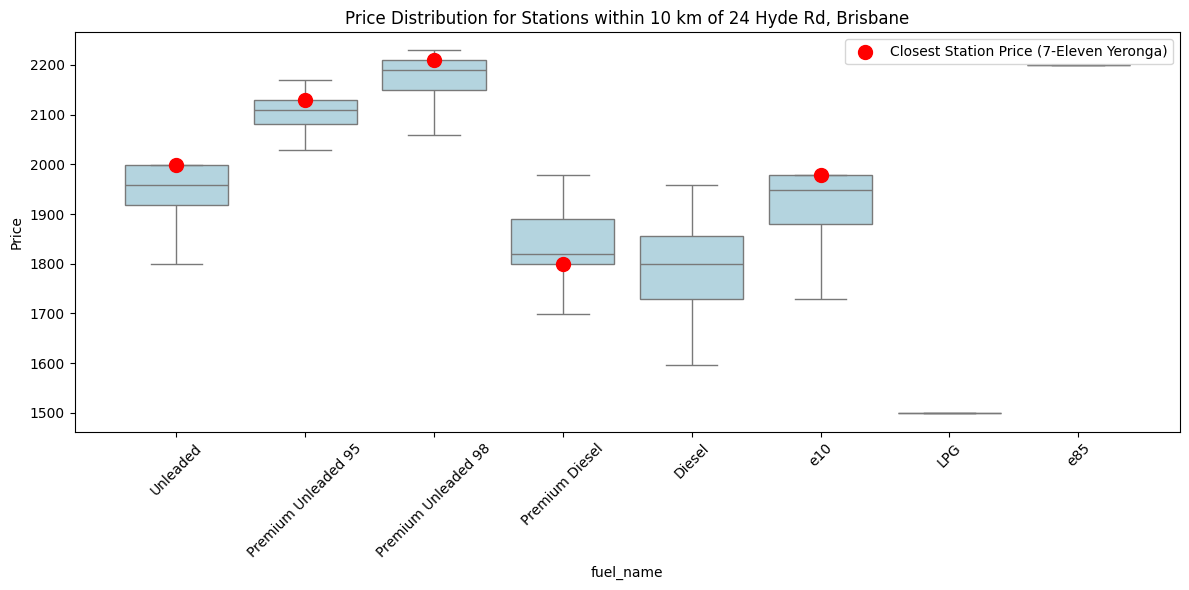

In [4]:
def find_stations_within_radius(address, stations_df, radius_km=10):
    # Get latitude and longitude for the input address
    address_lat_lon = get_lat_lon_from_address(address)  
    
    if address_lat_lon is None:
        print(f"Could not find coordinates for address: {address}")
        return None

    # Group by unique station (station_name, latitude, longitude, and site_id) to remove duplicates
    unique_stations = stations_df.groupby(['station_name', 'latitude', 'longitude', 'site_id'], as_index=False).first()

    # Calculate distance of all unique stations from the input address
    unique_stations['distance'] = unique_stations.apply(
        lambda row: calculate_distance(address_lat_lon, (row['latitude'], row['longitude'])), axis=1
    )

    # Filter stations within the specified radius
    stations_within_radius = unique_stations[unique_stations['distance'] <= radius_km]
    
    return stations_within_radius

def visualize_price_ranges_within_radius(address, final_df_filtered, radius_km=10):
    # Find all stations within the specified radius
    stations_within_radius = find_stations_within_radius(address, final_df_filtered, radius_km)
    
    if stations_within_radius is None or stations_within_radius.empty:
        print(f"No stations found within {radius_km} km of {address}")
        return

    print(f"Stations within {radius_km} km of {address}:")
    print(stations_within_radius[['station_name', 'distance']])

    # Prepare a DataFrame to hold data from the stations within the radius
    station_ids = stations_within_radius['site_id'].unique()
    data_within_radius = final_df_filtered[final_df_filtered['site_id'].isin(station_ids)]

    if data_within_radius.empty:
        print(f"No fuel price data found for stations within {radius_km} km.")
        return

    # Find the closest station
    closest_station = find_closest_stations(address, final_df_filtered, num_stations=1)

    if closest_station is None or closest_station.empty:
        print(f"No closest station found.")
        return

    # Get the name and ID of the closest station
    closest_station_name = closest_station['station_name'].values[0]
    closest_station_id = closest_station['site_id'].values[0]

    # Prepare data for the closest station
    closest_data = final_df_filtered[final_df_filtered['site_id'] == closest_station_id]

    # Create a figure for box plots
    plt.figure(figsize=(12, 6))

    # Create a box plot for all fuel types across the stations within the radius
    sns.boxplot(x='fuel_name', y='price', data=data_within_radius, color='lightblue', showfliers=False)

    # Add red dots for the closest station's prices
    for _, row in closest_data.iterrows():
        plt.scatter(x=row['fuel_name'], y=row['price'], color='red', zorder=10, s=100, 
                    label=f'Closest Station Price ({closest_station_name})' if row['fuel_name'] == closest_data['fuel_name'].values[0] else "")

    plt.title(f'Price Distribution for Stations within {radius_km} km of {address}')
    plt.ylabel('Price')

    # Add a legend
    plt.legend(loc='upper right')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

visualize_price_ranges_within_radius(address, final_df_filtered, radius_km=10)

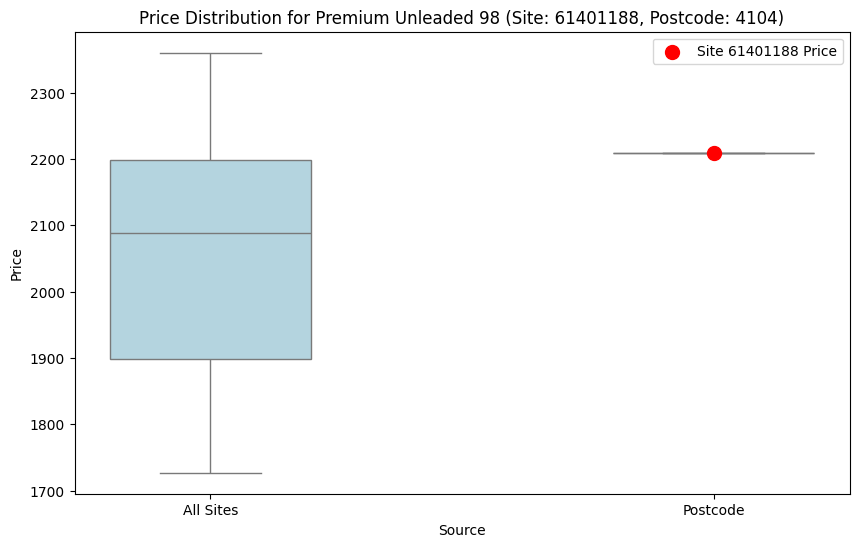

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


# Function to visualize price ranges using a box plot
def visualize_price_ranges_boxplot(fuel_name, site_id):
    # Filter the data for the given fuel_name
    df_fuel = final_df_filtered[final_df_filtered['fuel_name'] == fuel_name]
    
    # Get data for the specific site
    site_data = df_fuel[df_fuel['site_id'] == site_id]
    
    if site_data.empty:
        print(f"No data found for site_id: {site_id} and fuel_name: {fuel_name}")
        return
    
    site_price = site_data['price'].values[0]
    site_postcode = site_data['postcode'].values[0]
    
    # Filter the data for the same postcode
    df_postcode = df_fuel[df_fuel['postcode'] == site_postcode]
    
    # Create the box plot for all sites and the specific postcode
    plt.figure(figsize=(10, 6))

    # Create a new DataFrame to combine both boxes
    df_combined = pd.DataFrame({
        'Source': ['All Sites'] * len(df_fuel) + ['Postcode'] * len(df_postcode),
        'Price': list(df_fuel['price']) + list(df_postcode['price']),
    })

    # Create the box plot for all sites and the same postcode
    sns.boxplot(x='Source', y='Price', data=df_combined, color='lightblue', showfliers=False, width=0.4)

    # Add the specific site price as a red dot
    plt.scatter(x=['Postcode'], y=[site_price], color='red', zorder=10, s=100, label=f'Site {site_id} Price')
    
    plt.title(f'Price Distribution for {fuel_name} (Site: {site_id}, Postcode: {site_postcode})')
    plt.ylabel('Price')

    # Add a legend
    plt.legend(loc='upper right')
    
    plt.show()

# Example usage
fuel_name = 'Premium Unleaded 98'  # Replace with the desired fuel type
site_id = 61401188  # Replace with the actual site_id
visualize_price_ranges_boxplot(fuel_name, site_id)

In [29]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Haversine formula to calculate the distance between two lat/lng points
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Distance in kilometers
    distance = R * c
    return distance

# Function to get at least 5 site IDs within a dynamic radius (increasing by 10km until >= 5 sites)
def get_sites_within_dynamic_radius(df_sites_all, site_id, initial_radius_km=10):
    # Get the specified site's latitude and longitude
    site = df_sites_all[df_sites_all['Site ID'] == site_id]
    
    if site.empty:
        print(f"Site ID {site_id} not found.")
        return []
    
    site_lat = site['Latitude'].values[0]
    site_lon = site['Longitude'].values[0]
    
    radius_km = initial_radius_km
    nearby_sites = pd.DataFrame()
    
    # Keep increasing the radius by 10km until we find at least 5 sites
    while len(nearby_sites) < 5:
        # Apply the Haversine formula to calculate distance to all other sites
        df_sites_all['Distance'] = df_sites_all.apply(
            lambda row: haversine(site_lat, site_lon, row['Latitude'], row['Longitude']), axis=1
        )
        
        # Filter sites within the current radius
        nearby_sites = df_sites_all[df_sites_all['Distance'] <= radius_km]
        
        # If we don't have at least 5 sites, increase the radius
        if len(nearby_sites) < 5:
            radius_km += 10
    
    # Return a list of site IDs within the radius
    return nearby_sites, radius_km

# Example usage:
site_id = 61401441  # Replace with the specific Site ID
nearby_site_ids, final_radius = get_sites_within_dynamic_radius(df_sites_all, site_id)

print(f"Nearby sites within {final_radius}km of Site ID {site_id}: {nearby_site_ids}")



Nearby sites within 10km of Site ID 61401441:        Site ID                         Address                        Name   
70    61401177    246 Oxley Rd & Graceville Av         7-Eleven Graceville  \
71    61401180               624 Sherwood Road             United Sherwood   
72    61401183      534 Ipswich Rd & Ekibin Rd      Ampol Foodary Annerley   
73    61401185  180 Fairfield Rd & Brougham St  7-Eleven Fairfield Gardens   
74    61401188    563 Fairfield Rd & Nelson St            7-Eleven Yeronga   
...        ...                             ...                         ...   
1645  61478114              1329-1339 Logan Rd      7-Eleven Mount Gravatt   
1674  61478207              10-14 Lexington Rd          BP underwood South   
1680  61478213                  500 Learoyd Rd            Caltex Willawong   
1688  61478222                 47 Lensworth St       Caltex Coopers Plains   
1700  61478236                   19 Forest Way    NightOwl Shell Karawatha   

      Brand ID Po

In [30]:
# Function to get unleaded fuel prices for the sites within radius
def get_unleaded_prices(df_fuel_prices, nearby_sites):
    # Filter unleaded fuel prices (FuelId == 2)
    unleaded_prices = df_fuel_prices[(df_fuel_prices['FuelId'] == 2) & 
                                     (df_fuel_prices['SiteId'].isin(nearby_sites['Site ID']))]
    
    # Sort by SiteId and TransactionDateUtc to get the latest prices
    unleaded_prices_sorted = unleaded_prices.sort_values(by=['SiteId', 'TransactionDateUtc'], ascending=[True, False])
    
    # Drop duplicates, keeping the latest price for each site
    latest_unleaded_prices = unleaded_prices_sorted.drop_duplicates(subset='SiteId', keep='first')
    
    return latest_unleaded_prices[['SiteId', 'Price', 'TransactionDateUtc']]

# Example usage:
nearby_sites, final_radius = get_sites_within_dynamic_radius(df_sites_all, site_id)
unleaded_prices = get_unleaded_prices(df_fuel_prices, nearby_sites)

print(f"Unleaded prices for nearby sites: \n{unleaded_prices}")

Unleaded prices for nearby sites: 
        SiteId   Price       TransactionDateUtc
64    61401177  1559.0      2024-09-26T19:24:00
65    61401180  1555.0   2024-09-25T23:55:02.92
66    61401183  1669.0      2024-09-26T21:37:00
67    61401185  1999.0      2024-09-26T19:24:00
68    61401188  1999.0      2024-09-26T19:24:00
...        ...     ...                      ...
1475  61478047  1585.0      2024-09-22T11:07:45
1505  61478114  1599.0      2024-09-26T19:24:00
1536  61478213  1999.0  2024-09-25T08:02:55.093
1544  61478222  1546.0   2024-09-24T19:14:26.82
1554  61478236  1639.0  2024-09-22T02:25:01.627

[123 rows x 3 columns]


In [45]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta

# Convert 'TransactionDateUtc' to datetime
df_fuel_prices['TransactionDateUtc'] = pd.to_datetime(df_fuel_prices['TransactionDateUtc'], errors='coerce')

# Merge fuel prices with site information to get site names
df_fuel_prices_merged = pd.merge(df_fuel_prices, df_sites_all, left_on='SiteId', right_on='Site ID')

# Calculate the IQR and filter out outliers
Q1 = df_fuel_prices_merged['Price'].quantile(0.25)
Q3 = df_fuel_prices_merged['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_fuel_prices_merged_filtered = df_fuel_prices_merged[(df_fuel_prices_merged['Price'] >= lower_bound) & 
                                                       (df_fuel_prices_merged['Price'] <= upper_bound)]

# Get the current date and filter data for the last 1 month
one_month_ago = datetime.now() - timedelta(days=15)
df_fuel_prices_last_month = df_fuel_prices_merged_filtered[df_fuel_prices_merged_filtered['TransactionDateUtc'] >= one_month_ago]

# Get the min and max prices for each date to show the overall trend range
price_range = df_fuel_prices_last_month.groupby('TransactionDateUtc')['Price'].agg(['min', 'max']).reset_index()

# Select a specific site to plot its trend (e.g., Site A with SiteId 61290151)
specific_site_id = 61290151
site_price_trend = df_fuel_prices_last_month[df_fuel_prices_last_month['SiteId'] == specific_site_id]

# Create the plot
fig = go.Figure()

# Add shaded area for the overall trend range (min-max) for all sites
fig.add_trace(go.Scatter(
    x=price_range['TransactionDateUtc'],
    y=price_range['max'],
    mode='lines',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=price_range['TransactionDateUtc'],
    y=price_range['min'],
    fill='tonexty',  # Fill between the min and max lines
    mode='lines',
    line=dict(width=0),
    fillcolor='rgba(173, 216, 230, 0.4)',  # Light blue fill color for range
    name='Overall Trend Range'
))

# Add line for the specific site's price trend
fig.add_trace(go.Scatter(
    x=site_price_trend['TransactionDateUtc'],
    y=site_price_trend['Price'],
    mode='lines+markers',
    line=dict(color='blue', width=2),
    marker=dict(size=8),
    name=f"Price Trend for Site {specific_site_id}"
))

# Customize layout
fig.update_layout(
    title=f'Fuel Price Trend for Site {specific_site_id} (Last Month)',
    xaxis_title='Transaction Date',
    yaxis_title='Price (in cents)',
    template='plotly_white',
    font=dict(family="Arial", size=14, color="black"),
    plot_bgcolor="white",
    hovermode="x unified",
    margin=dict(l=40, r=40, t=100, b=40)
)

# Show the figure
fig.show()

In [38]:
import pandas as pd
import plotly.express as px
from datetime import datetime, timedelta

# Convert TransactionDateUtc to datetime
unleaded_prices['TransactionDateUtc'] = pd.to_datetime(unleaded_prices['TransactionDateUtc'], errors='coerce')

# Merge 'unleaded_prices' with 'df_sites_all' to get site names
unleaded_prices_merged = pd.merge(unleaded_prices, df_sites_all, left_on='SiteId', right_on='Site ID')

# Find the highlight site name from df_sites_all using the given site_id
highlight_site_id = site_id
highlight_site_name = df_sites_all[df_sites_all['Site ID'] == highlight_site_id]['Name'].values[0]

# Merge 'unleaded_prices' with 'df_sites_all' to get site names
unleaded_prices_merged = pd.merge(unleaded_prices, df_sites_all, left_on='SiteId', right_on='Site ID')

# Calculate the last 5 days from the current date
today = datetime.now()
five_days_ago = today - timedelta(days=5)

# Separate older and last 5 days data
last_five_days = unleaded_prices_merged[unleaded_prices_merged['TransactionDateUtc'] >= five_days_ago]
older_data = unleaded_prices_merged[unleaded_prices_merged['TransactionDateUtc'] < five_days_ago]

# Merge older data by averaging the prices and setting a fixed x-axis value for older data
if not older_data.empty:
    avg_price_old = older_data['Price'].mean()
    merged_old = pd.DataFrame({
        'TransactionDateUtc': [five_days_ago - timedelta(days=1)],  # Fixed date for "Older" data
        'Price': [avg_price_old],
        'Name': ['Older Data'],
        'SiteId': [None]
    })
    
    # Append the merged old data to the last 5 days
    last_five_days = pd.concat([last_five_days, merged_old])

# Create the Plotly chart with customizations
fig = px.scatter(
    last_five_days,
    x='TransactionDateUtc',
    y='Price',
    hover_name='Name',
    title='Unleaded Prices Over the Last 5 Days',
    labels={"TransactionDateUtc": "Transaction Date", "Price": "Price (in cents)"},
    template='plotly_white'  # Applying a cleaner theme
)

# Highlight the specific site (example: SiteId 61290151)
highlight_site_id = 61290151
highlight_site_row = last_five_days[last_five_days['SiteId'] == highlight_site_id]

# Customize layout to make it prettier
fig.update_layout(
    title={
        'text': "Unleaded Prices Over Time",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, color='black')
    },
    xaxis_title="Date",
    yaxis_title="Price (in cents)",
    font=dict(family="Arial", size=14, color="black"),
    plot_bgcolor="white",
    hovermode="x unified",
    xaxis=dict(showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(showline=True, linewidth=2, linecolor='black', mirror=True),
    margin=dict(l=40, r=40, t=100, b=40)
)

# Add gridlines and opacity
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# If we have a highlight, make the dot smaller and red
if not highlight_site_row.empty:
    fig.add_trace(go.Scatter(
        x=highlight_site_row['TransactionDateUtc'],
        y=highlight_site_row['Price'],
        mode='markers',
        marker=dict(size=10, color='red', line=dict(width=2, color='DarkSlateGrey')),
        name="Highlighted Site"
    ))

# Show the figure
fig.show()